# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# CV2 (for checking)

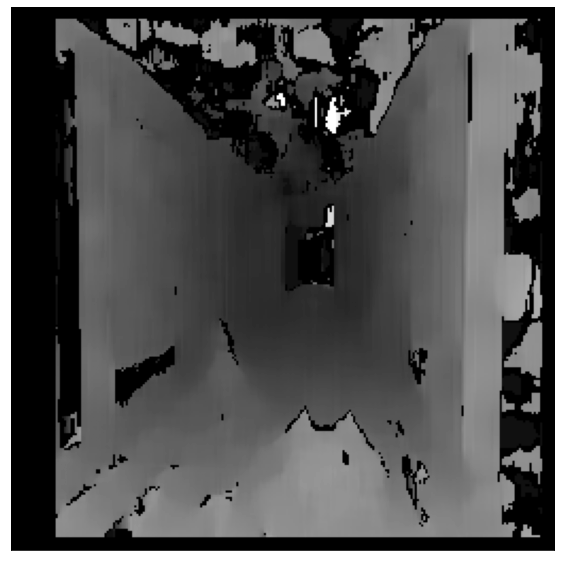

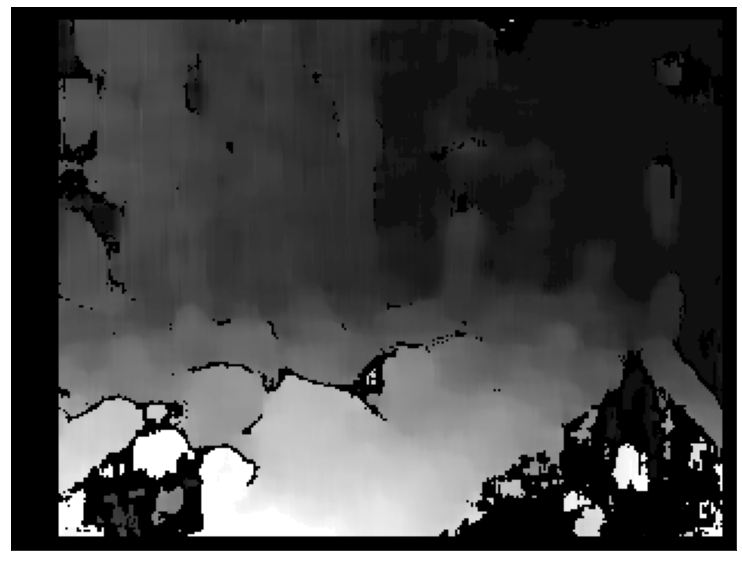

In [76]:
#### uses cv2 for comparison ####
import cv2

for i in range(2):
    # import left and right images as greyscale and convert to numpy array
    if (i == 0):
        # corridor image set
        left_img = "corridorl.jpg"
        right_img = "corridorr.jpg"
    else:
        # triclopsi2 image set
        left_img = "triclopsi2l.jpg"
        right_img = "triclopsi2r.jpg"
    
    imgL = cv2.imread(left_img, 0)
    imgR = cv2.imread(right_img, 0)

    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=13)
    disparity = stereo.compute(imgL,imgR)
    # plt.figure()
    plt.figure(figsize = (20,10))
    plt.imshow(disparity,'gray')
    plt.xticks([])
    plt.yticks([])

# import image

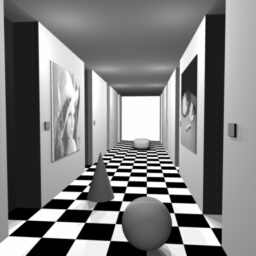

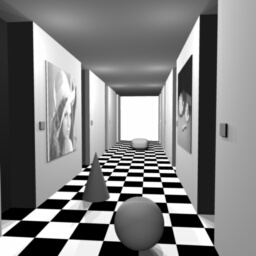

Images have same dimensions, good to proceed


In [21]:
## choose either corridor or triclopsi2 image set

# corridor image set
left_img = "corridorl.jpg"
right_img = "corridorr.jpg"

# # triclopsi2 image set
# left_img = "triclopsi2l.jpg"
# right_img = "triclopsi2r.jpg"

left_img = Image.open(left_img)
left_img = left_img.convert(mode='L')
display(left_img)
left_img = np.asarray(left_img)

right_img = Image.open(right_img)
right_img = right_img.convert(mode='L')
display(right_img)
right_img = np.asarray(right_img)

# check if left image same size as right image
if left_img.shape == right_img.shape:
    print('Images have same dimensions, good to proceed')
else:
    print('Images do not have same dimensions, recheck image file selections')


# Define functions

In [4]:
# get the index of the minimum Sum of Squared Difference in the row
def row_wise_comparison(row_idx, col_idx, patch_size, img_width, search_width):
    """
    row_idx, col_idx: index of the pixel of interest of the left image in the center of patch
    patch_size: size of patch, must be N pixels above, below, left, and right of the center pixel, therefore
    2N + 1, must be odd number
    img_width: horizontal size of image 
    search_width: the horizontal search size (in pixels) for the right image to the left and right 
    of the pixel of interest
    """
    N = int((patch_size - 1) / 2)
    
    # define row-wise search area on right image, constrained to border of thickness N
    col_min_idx = max(N, col_idx-search_width) # left limit of col_idx
    col_max_idx = min(img_width-N, col_idx+search_width) # right limit of col_idx
    
    # initialize dist from col_idx
    old_dist = max(col_idx - col_min_idx, col_max_idx - col_idx)
    
    # initialize min_SSD as maximum difference possible
    min_SSD = (255**2) * (patch_size**2)
    
    # intitialize min_idx as first search index
    min_idx = col_min_idx
    
    # define patch of left image for comparison
    left_patch = left_img[(row_idx-N):(row_idx+N+1), (col_idx-N):(col_idx+N+1)]
#     print(f'left patch array at {row_idx, col_idx}: \n {left_patch}')

    # repeat for search_width
    for i in range(col_min_idx, col_max_idx):
        
        # define right patch area
        right_patch = right_img[(row_idx-N):(row_idx+N+1), (i-N):(i+N+1)]
#         print(f'right patch array at {row_idx, i}: \n {right_patch}')

        # get Sum of Squared Difference between left and right patches
        SSD_patch = ((right_patch - left_patch)**2).sum()
        print(f'idx: {i}, \t SSD: {SSD_patch}')
        
        # get current absolute dist from col_idx
        new_dist = abs(i-col_idx)
        
        # if the SSD of current patch is smaller than previous smallest SSD
        if SSD_patch < min_SSD:
            
            # save min_SSD and min_idx of the patch
            min_SSD = SSD_patch
            min_idx = i
        
        # if the SSD of current patch is equal to previous smallest SSD but nearer to col_idx
        elif SSD_patch == min_SSD and new_dist < old_dist:
            
            # save min_SSD and min_idx of the patch
            min_SSD = SSD_patch
            min_idx = i
        
        # update old_dist
        old_dist = new_dist
        
    return min_SSD, min_idx
        
    
# get the disparity map of the entire image
def get_disparity_map(left_img, right_img, patch_size, search_width):
    
    # get image height and width
    img_height = left_img.shape[0]
    img_width = left_img.shape[1]
    
    N = int((patch_size - 1) / 2)
#     print(f'N is {N}, img height is {img_height}, img width is {img_width}')

    # initialize disparity map array
    disparity_SSD_map = np.zeros((img_height, img_width)) # may not be required
    disparity_map = np.zeros((img_height, img_width))
    
    # get disparity map for every possible pixel in left_img, constrained to border of size N
    for i in range(N, img_height - N):
        for j in range(N, img_width - N):
            min_SSD, min_idx = row_wise_comparison(i, j, patch_size, img_width, search_width)
            disparity_SSD_map[i,j] = min_SSD
            disparity_map[i,j] = j - min_idx

    disparity_SSD_map = np.floor(255 * (disparity_SSD_map / np.amax(disparity_SSD_map)))
    return disparity_SSD_map.astype('uint8'), disparity_map


# Algorithm

Image set: Corridor


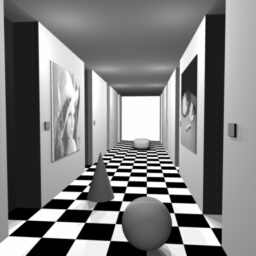

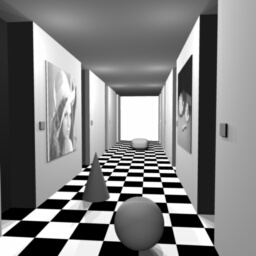

Patch size: 13, 	 maximum search width: 39
Disparity map:


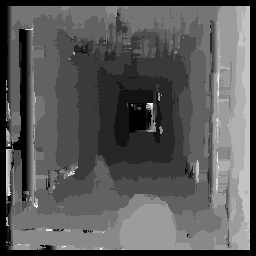

Image set: triclopsi2


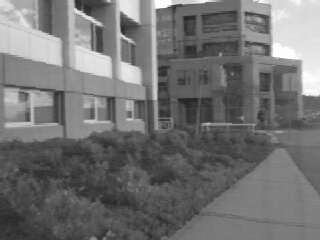

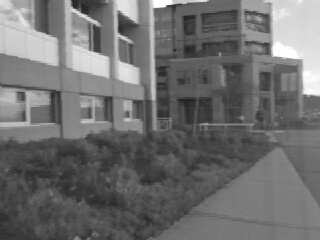

Patch size: 13, 	 maximum search width: 39
Disparity map:


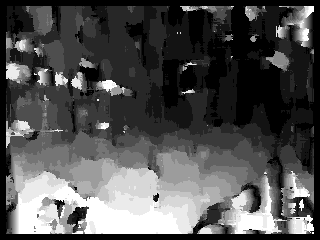

In [3]:
for i in range(2):
    # import left and right images as greyscale and convert to numpy array
    if (i == 0):
        # corridor image set
        left_img_file = "corridorl.jpg"
        right_img_file = "corridorr.jpg"
        save_filename = "corridor_disparity_map.jpg"
        print('Image set: Corridor')
    else:
        # triclopsi2 image set
        left_img_file = "triclopsi2l.jpg"
        right_img_file = "triclopsi2r.jpg"
        save_filename = "triclopsi2_disparity_map.jpg"
        print('Image set: triclopsi2')
        
    left_img = Image.open(left_img_file)
    left_img = left_img.convert(mode='L')
    display(left_img)
    left_img = np.asarray(left_img)

    right_img = Image.open(right_img_file)
    right_img = right_img.convert(mode='L')
    display(right_img)
    right_img = np.asarray(right_img)
    
    # set parameters
    patch_size = 13 # Must be 2*N + 1
    multiplier = 1
    search_width = patch_size * multiplier
    N = (patch_size-1)//2
    print(f'Patch size: {patch_size}, \t maximum search width: {2*N + search_width*2 + 1}')

    # get disparity map
    disparity_SSD_map, disparity_map = get_disparity_map(left_img, right_img, patch_size, search_width)
    
#     print('SSD map:')
#     disparity_SSD_map_img = Image.fromarray(disparity_SSD_map, mode="L")
#     display(disparity_SSD_map_img)
    
    # disparity map to be upscaled for clearer depiction of disparity
    # brighter areas means larger disparity differences, meaning closer to camera
    print('Disparity map:')
    disparity_map = abs(disparity_map)
    disparity_map = disparity_map.astype('uint8')
    disparity_map = np.floor(255 * (disparity_map / np.amax(disparity_map)))
    disparity_map = disparity_map.astype('uint8')
    disparity_map_img = Image.fromarray(disparity_map, mode="L")
    display(disparity_map_img)
    
    # save image
#     disparity_map_img.save(save_filename)



# Find best parameters visually

patch size:  5 	 search width:  5


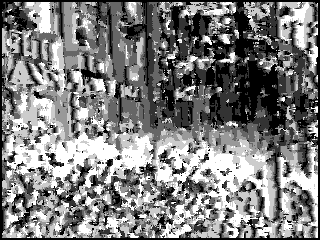

patch size:  5 	 search width:  10


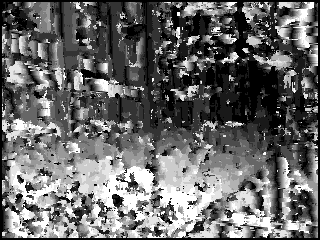

patch size:  5 	 search width:  15


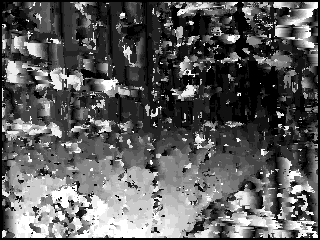

patch size:  5 	 search width:  20


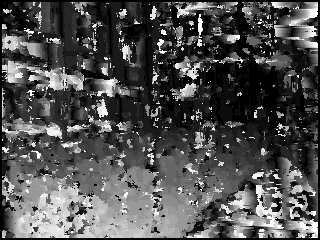

patch size:  7 	 search width:  7


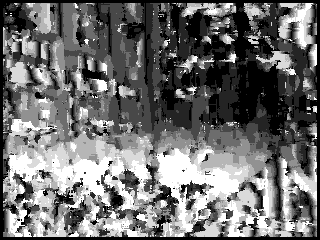

patch size:  7 	 search width:  14


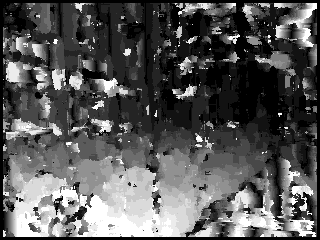

patch size:  7 	 search width:  21


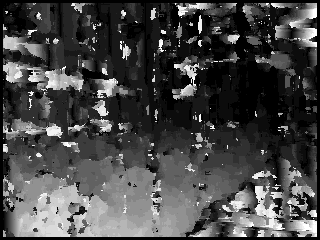

patch size:  7 	 search width:  28


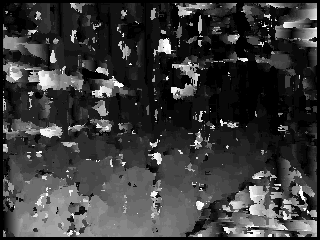

patch size:  9 	 search width:  9


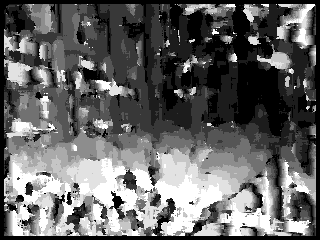

patch size:  9 	 search width:  18


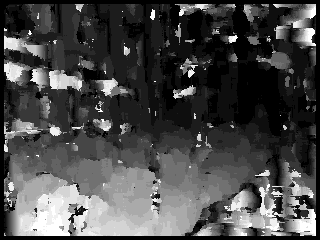

patch size:  9 	 search width:  27


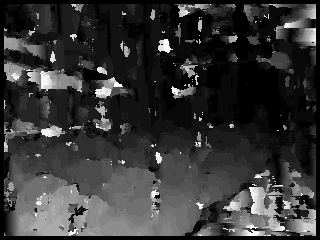

patch size:  9 	 search width:  36


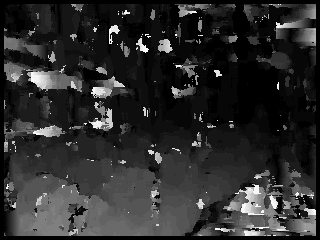

patch size:  11 	 search width:  11


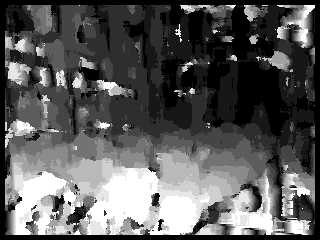

patch size:  11 	 search width:  22


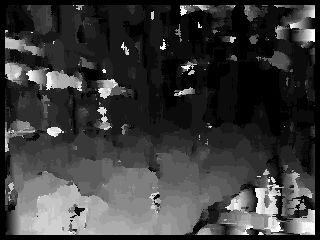

patch size:  11 	 search width:  33


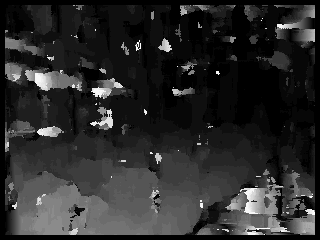

patch size:  11 	 search width:  44


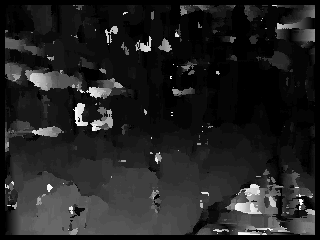

patch size:  13 	 search width:  13


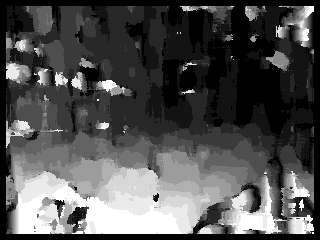

patch size:  13 	 search width:  26


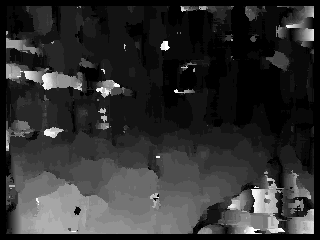

patch size:  13 	 search width:  39


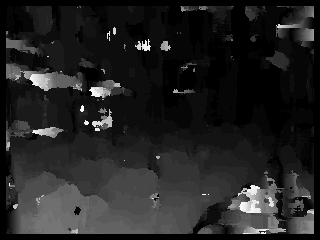

patch size:  13 	 search width:  52


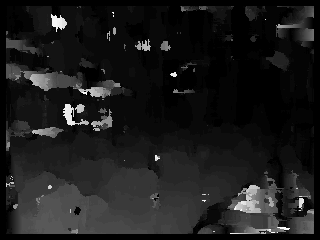

patch size:  15 	 search width:  15


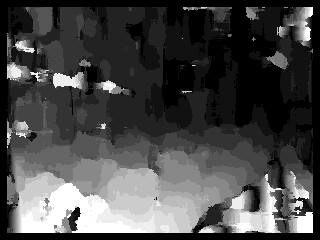

patch size:  15 	 search width:  30


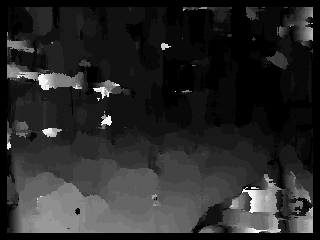

patch size:  15 	 search width:  45


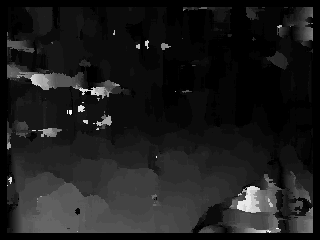

patch size:  15 	 search width:  60


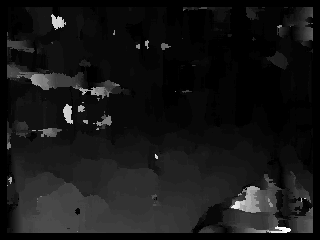

patch size:  17 	 search width:  17


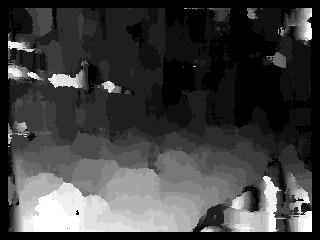

patch size:  17 	 search width:  34


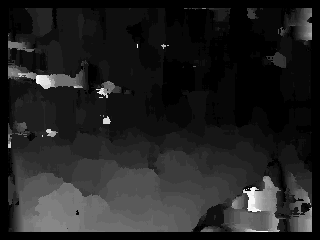

patch size:  17 	 search width:  51


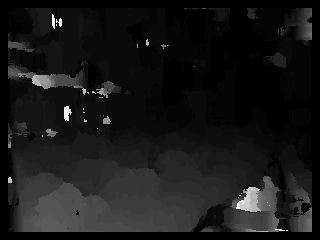

patch size:  17 	 search width:  68


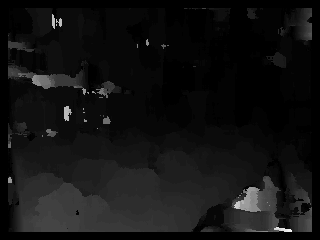

patch size:  19 	 search width:  19


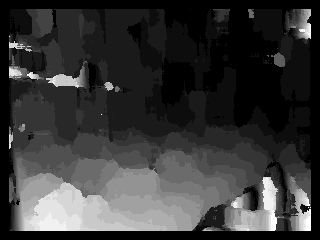

patch size:  19 	 search width:  38


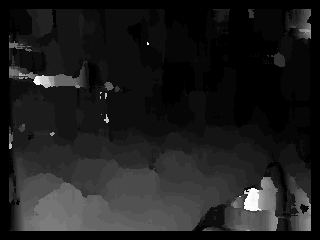

patch size:  19 	 search width:  57


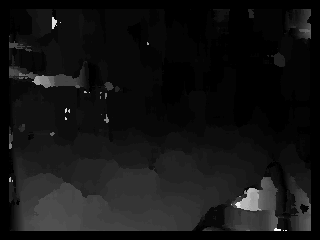

patch size:  19 	 search width:  76


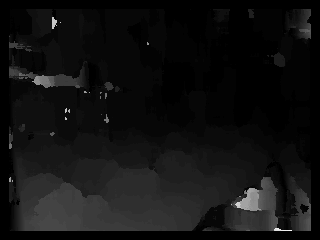

patch size:  21 	 search width:  21


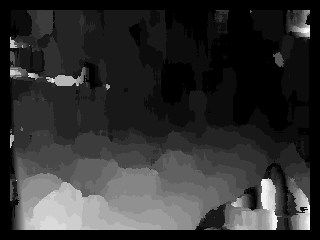

patch size:  21 	 search width:  42


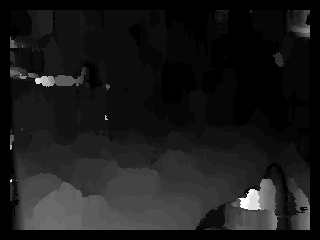

patch size:  21 	 search width:  63


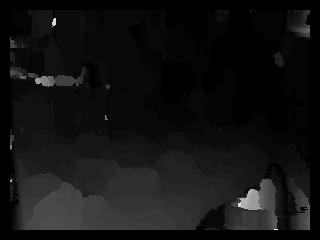

patch size:  21 	 search width:  84


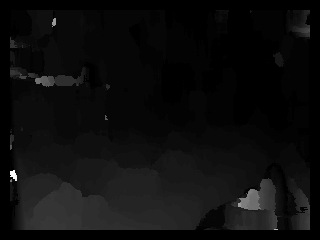

patch size:  23 	 search width:  23


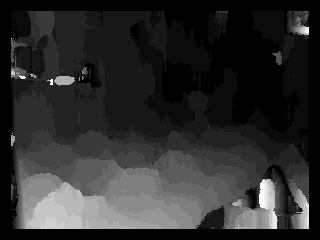

patch size:  23 	 search width:  46


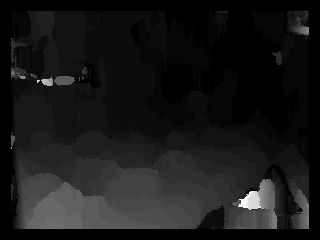

patch size:  23 	 search width:  69


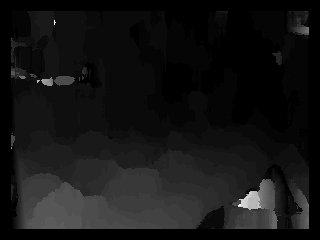

patch size:  23 	 search width:  92


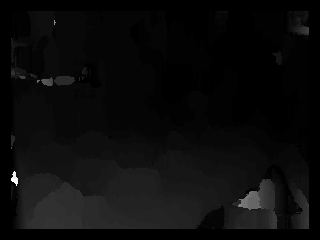

patch size:  25 	 search width:  25


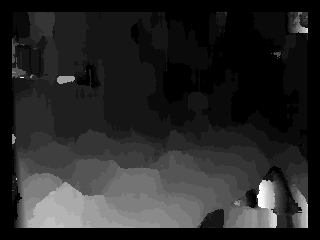

patch size:  25 	 search width:  50


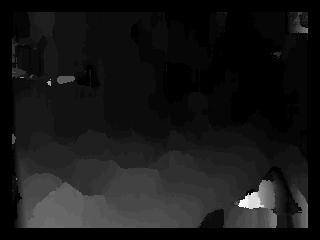

patch size:  25 	 search width:  75


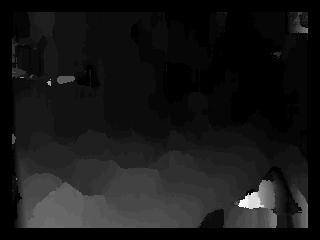

patch size:  25 	 search width:  100


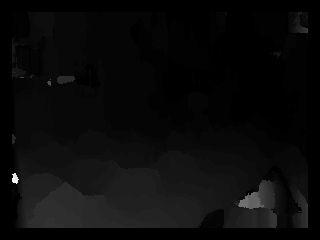

In [36]:
########################## for finding best parameters visually

## Set parameters 
patch_size = [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25] # Must be 2*N + 1
# img_width = left_img.shape[1]
multiplier = [1, 2, 3, 4]
for i in patch_size:
    for j in multiplier:
        N = int(i-1)//2
        search_width = i * j
        print('patch size: ', i, '\t search width: ', search_width)
        disparity_SSD_map, disparity_map = get_disparity_map(left_img, right_img, i, search_width)
#         disparity_SSD_map_img = Image.fromarray(disparity_SSD_map, mode="L")
#         display(disparity_SSD_map_img)

        disparity_map = abs(disparity_map)
        disparity_map = disparity_map.astype('uint8')
        disparity_map = np.floor(255 * (disparity_map / np.amax(disparity_map)))
        disparity_map = disparity_map.astype('uint8')
        disparity_map_img = Image.fromarray(disparity_map, mode="L")
        display(disparity_map_img)

# triclopsi2

#9,2 
#11,2
#13,1
#15,1
#17,1

# corridor

#13,1
#15,1
#17,1

# Checks

In [7]:
## Import image ##
# # corridor image set
# left_img = "corridorl.jpg"
# right_img = "corridorr.jpg"

# triclopsi2 image set
left_img = "triclopsi2l.jpg"
right_img = "triclopsi2r.jpg"

left_img = Image.open(left_img)
left_img = left_img.convert(mode='L')
# display(left_img)
left_img = np.asarray(left_img)

right_img = Image.open(right_img)
right_img = right_img.convert(mode='L')
# display(right_img)
right_img = np.asarray(right_img)

## Set parameters ##
patch_size = 13 # Must be 2*N + 1
N = (patch_size-1)//2
img_width = left_img.shape[1]
search_width = patch_size * 1

check_idx = np.asarray([82,110])
print(f'left img idx: [{check_idx[0]},{check_idx[1]}]')
print(f'Col_idx of right img \t SSD value')
      
min_SSD, min_idx = row_wise_comparison(check_idx[0], check_idx[1], patch_size, img_width, search_width)
print(f'right img best patch idx: [{check_idx[0]},{min_idx}], disparity: {check_idx[1] - min_idx} \t min_SSD: {min_SSD}')

left_orig_area = left_img[check_idx[0]-N:check_idx[0]+N+1,check_idx[1]-N:check_idx[1]+N+1]
right_orig_area = right_img[check_idx[0]-N:check_idx[0]+N+1,check_idx[1]-N:check_idx[1]+N+1]
right_similar_area = right_img[check_idx[0]-N:check_idx[0]+N+1,min_idx-N:min_idx+N+1]

print(f'left_orig_area: \n {left_orig_area}')
print(f'right_orig_area: \n {right_orig_area}')
print(f'right_similar_area: \n {right_similar_area}')
# left_orig_area = Image.fromarray(left_orig_area, mode="L")
# plt.figure(figsize = (patch_size*2,patch_size*2))
# plt.imshow(left_orig_area,'gray')
# plt.title('left_orig_area')
# plt.xticks([])
# plt.yticks([])

# right_orig_area = Image.fromarray(right_orig_area, mode="L")
# plt.figure(figsize = (patch_size*2,patch_size*2))
# plt.imshow(right_orig_area,'gray')
# plt.title('right_orig_area')
# plt.xticks([])
# plt.yticks([])

# right_similar_area = Image.fromarray(right_similar_area, mode="L")
# plt.figure(figsize = (patch_size*2,patch_size*2))
# plt.imshow(right_similar_area,'gray')
# plt.title('right_similar_area')
# plt.xticks([])
# plt.yticks([])

SSD_1 = ((left_orig_area - right_orig_area)**2).sum()
SSD_2 = ((left_orig_area - right_similar_area)**2).sum()
print(f'original area SSD: {SSD_1}, \t best area SSD: {SSD_2}')


left img idx: [82,110]
Col_idx of right img 	 SSD value
idx: 97, 	 SSD: 5627
idx: 98, 	 SSD: 6202
idx: 99, 	 SSD: 7171
idx: 100, 	 SSD: 7582
idx: 101, 	 SSD: 8491
idx: 102, 	 SSD: 7463
idx: 103, 	 SSD: 7622
idx: 104, 	 SSD: 7232
idx: 105, 	 SSD: 8185
idx: 106, 	 SSD: 8289
idx: 107, 	 SSD: 7901
idx: 108, 	 SSD: 6843
idx: 109, 	 SSD: 8190
idx: 110, 	 SSD: 10824
idx: 111, 	 SSD: 11853
idx: 112, 	 SSD: 12642
idx: 113, 	 SSD: 10949
idx: 114, 	 SSD: 11135
idx: 115, 	 SSD: 11405
idx: 116, 	 SSD: 13931
idx: 117, 	 SSD: 12967
idx: 118, 	 SSD: 11416
idx: 119, 	 SSD: 11543
idx: 120, 	 SSD: 11311
idx: 121, 	 SSD: 10370
idx: 122, 	 SSD: 10516
right img best patch idx: [82,97], disparity: 13 	 min_SSD: 5627
left_orig_area: 
 [[180 190 200 205 211 204 207 196 159 142 139 148 158]
 [147 151 153 156 171 173 196 191 154 138 134 141 150]
 [147 149 152 156 167 166 177 169 149 137 134 137 142]
 [148 149 151 149 150 148 152 148 150 142 140 136 131]
 [146 148 149 150 149 148 148 149 146 144 140 140 143]
 [15

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


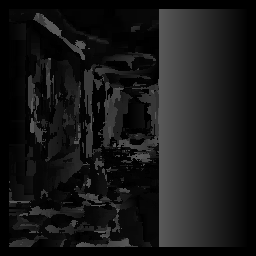

In [53]:
def sum_of_abs_diff(pixel_vals_1, pixel_vals_2):
    """
    Args:
        pixel_vals_1 (numpy.ndarray): pixel block from left image
        pixel_vals_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of absolute difference between individual pixels
    """
    if pixel_vals_1.shape != pixel_vals_2.shape:
        return -1

    return np.sum(abs(pixel_vals_1 - pixel_vals_2))

BLOCK_SIZE = 7
SEARCH_BLOCK_SIZE = 56

def compare_blocks(y, x, block_left, right_array, block_size=5):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.

    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                    Defaults to 5.

    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    # Get search range for the right image
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_array.shape[1], x + SEARCH_BLOCK_SIZE)
    #print(f'search bounding box: ({y, x_min}, ({y, x_max}))')
    first = True
    min_sad = None
    min_index = None
    for x in range(x_min, x_max):
        block_right = right_array[y: y+block_size, x: x+block_size]
        sad = sum_of_abs_diff(block_left, block_right)
        #print(f'sad: {sad}, {y, x}')
        if first:
            min_sad = sad
            min_index = (y, x)
            first = False
        else:
            if sad < min_sad:
                min_sad = sad
                min_index = (y, x)

    return min_index

h, w = left_img.shape
disparity_map = np.zeros((h, w))
# min_index = compare_blocks(y, x, block_left, right_img, block_size=BLOCK_SIZE)
# disparity_map[y, x] = abs(min_index[1] - x)

for y in range(BLOCK_SIZE, h-BLOCK_SIZE):
    for x in range(BLOCK_SIZE, w-BLOCK_SIZE):
        block_left = left_img[y:y + BLOCK_SIZE, x:x + BLOCK_SIZE]
        min_index = compare_blocks(y, x, block_left, right_img, block_size=BLOCK_SIZE)
        disparity_map[y, x] = abs(min_index[1] - x)
        
print(disparity_map)
eq_img = Image.fromarray(disparity_map.astype('uint8'))
display(eq_img)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])